In [3]:
!pip install pmdarima
!pip install optuna
!pip install "numpy<2"
!pip install tensorflow
!pip install pyod
!pip install sktime
import optuna as op
import plotly as px
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.linalg import LinAlgError
from scipy import stats
from pyod.models.abod import ABOD
import plotly.express as pex
import plotly.graph_objects as go
from pmdarima import auto_arima
from xgboost import XGBRegressor
from sktime.forecasting.trend import PolynomialTrendForecaster

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error,
                             mean_absolute_error,
                             mean_absolute_percentage_error,
                             r2_score)
from sklearn.preprocessing import (MinMaxScaler,
                                   StandardScaler,
                                   PowerTransformer,
                                   RobustScaler)
from sklearn.model_selection import (train_test_split,
                                     TimeSeriesSplit)
from sklearn.ensemble import (IsolationForest,
                              RandomForestRegressor)
from sklearn.svm import OneClassSVM

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import (plot_acf,
                                           plot_pacf)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from keras.optimizers import Adam
from keras.models import (Sequential,
                          Model)
from keras.layers import (LSTM,
                          GRU,
                          Dense,
                          Input,
                          RepeatVector)

Размеры датасета
Строк: 852
Столбцов: 4

Кол-во пропущенных значений: 0

Колонки и их типы:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852 entries, 0 to 851
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Учетный день                 852 non-null    object 
 1   Количество гостей            852 non-null    int64  
 2   Сумма без скидки, р.         852 non-null    float64
 3   Средняя выручка с гостя, р.  852 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 26.8+ KB
None

Пропусков нет

====================================================Графики распределений и корреляции====================================================


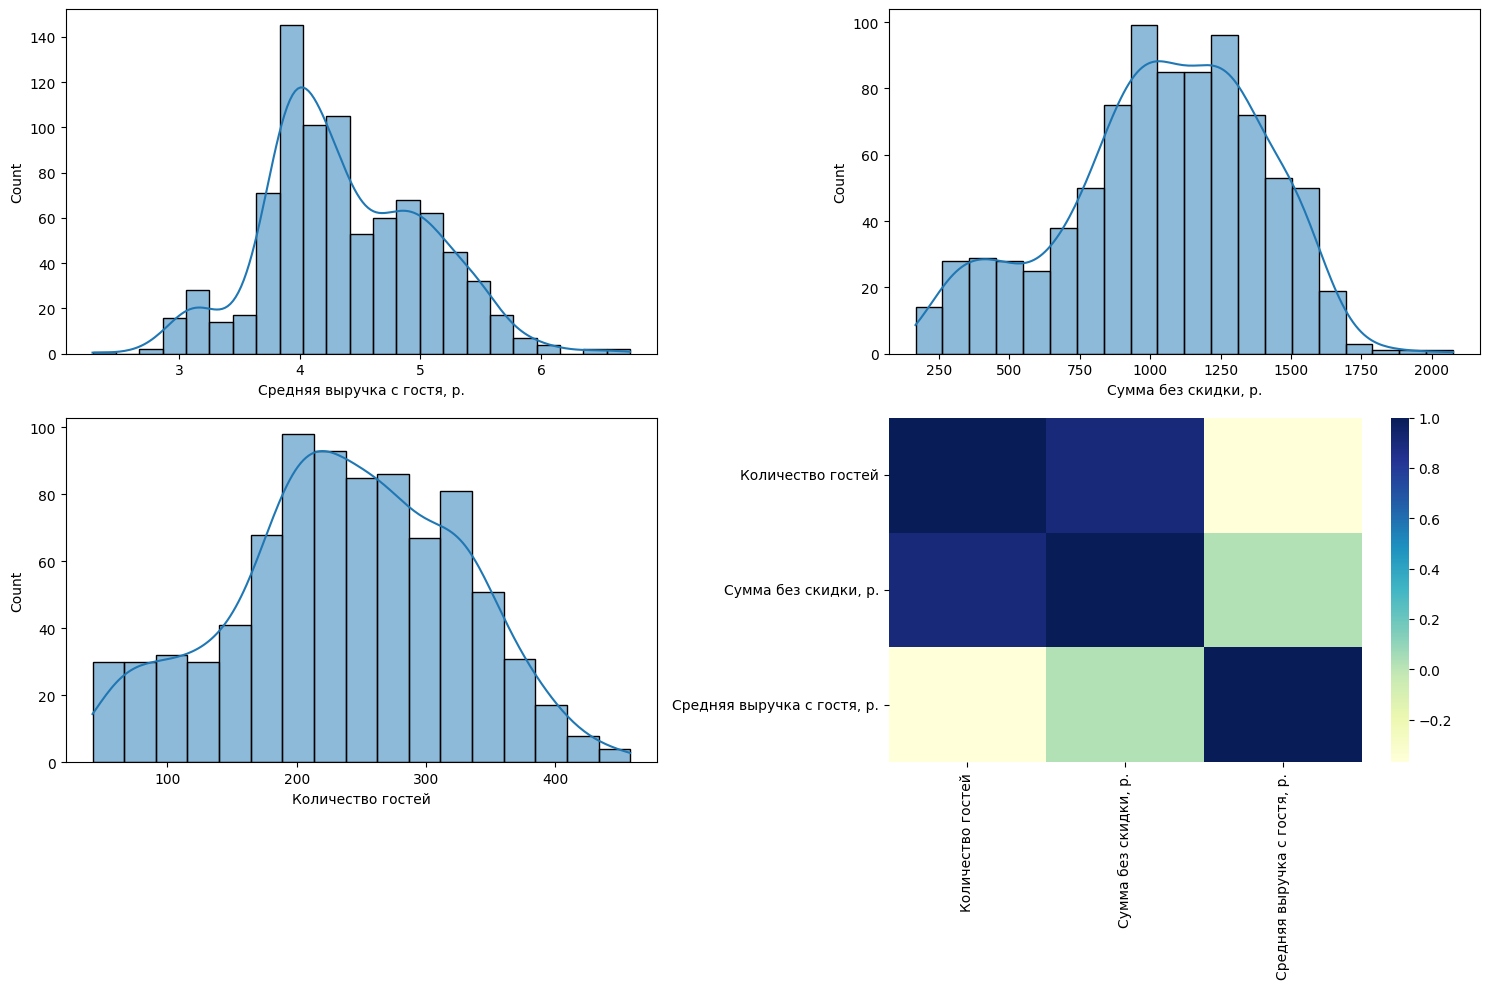

АНАЛИЗ РАСПРЕДЕЛЕНИЯ ДАННЫХ
Общее количество наблюдений: 852
Минимум: 167.01
Максимум: 2075.50
Среднее: 1040.98
Медиана: 1070.78
Стандартное отклонение: 351.61
Асимметрия: -0.409
Эксцесс: -0.362
Тест на нормальность: p-value = 0.000001
Данные НЕ нормальные


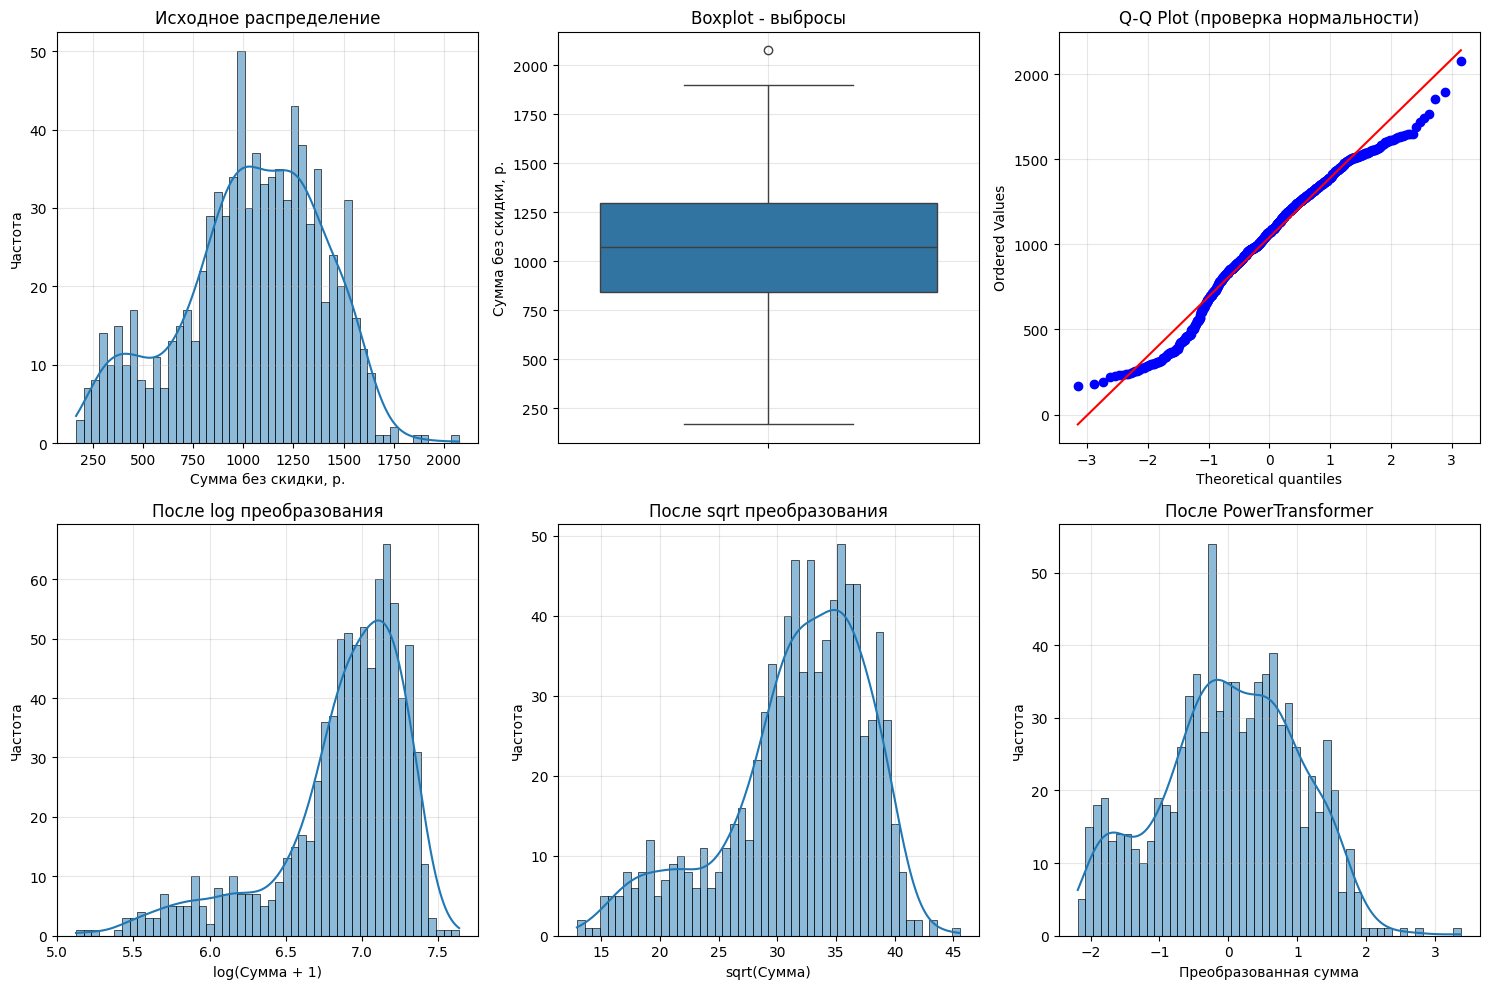


АНАЛИЗ ВЫБРОСОВ:
Q1 (25-й перцентиль): 843.04
Q3 (75-й перцентиль): 1298.75
IQR: 455.71
Нижняя граница: 159.48
Верхняя граница: 1982.31
Количество выбросов: 1
Процент выбросов: 0.12%


In [4]:
file_path  = 'dombyta.csv'
df = pd.read_csv(file_path)

print("Размеры датасета")
print(f"Строк: {df.shape[0]}")
print(f"Столбцов: {df.shape[1]}")
print('='*60)
print(f"\nКол-во пропущенных значений: {df.isna().sum().sum()}\n")
print('='*60)
print("Колонки и их типы:")
print(f"{df.info()}")
print('='*60)
if df.isna().sum().sum() != 0:
  print('\nПрисутствуют пропуски:\n')
  print(f"\n{df.isna().sum()}\n")
else:
  print(f"\nПропусков нет\n")

print('='*52 + 'Графики распределений и корреляции' + '='*52)
fig, axes = plt.subplots(2,2, figsize = (15, 10))
axes = axes.ravel()

sns.histplot(df['Средняя выручка с гостя, р.'], ax=axes[0], kde=True)
sns.histplot(df['Сумма без скидки, р.'], ax=axes[1], kde=True)
sns.histplot(df['Количество гостей'], ax=axes[2], kde=True)
sns.heatmap(df.drop('Учетный день',axis=1).corr(), ax=axes[3], cmap='YlGnBu')

plt.tight_layout()
plt.show()

fig = px.plot(df, x=df['Учетный день'], y=df['Сумма без скидки, р.'], kind='scatter')
fig.show()

data = df['Сумма без скидки, р.'].values

print("="*50)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ДАННЫХ")
print("="*50)

# Базовая статистика
print(f"Общее количество наблюдений: {len(data)}")
print(f"Минимум: {np.min(data):.2f}")
print(f"Максимум: {np.max(data):.2f}")
print(f"Среднее: {np.mean(data):.2f}")
print(f"Медиана: {np.median(data):.2f}")
print(f"Стандартное отклонение: {np.std(data):.2f}")
print(f"Асимметрия: {stats.skew(data):.3f}")
print(f"Эксцесс: {stats.kurtosis(data):.3f}")

# Проверка на нормальность
stat, p_value = stats.normaltest(data)
print(f"Тест на нормальность: p-value = {p_value:.6f}")
print(f"Данные {'нормальные' if p_value > 0.05 else 'НЕ нормальные'}")

# Детальная визуализация распределения
plt.figure(figsize=(15, 10))

# 1. Гистограмма с ядром плотности
plt.subplot(2, 3, 1)
sns.histplot(data, kde=True, bins=50)
plt.title('Исходное распределение')
plt.xlabel('Сумма без скидки, р.')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# 2. Boxplot
plt.subplot(2, 3, 2)
sns.boxplot(y=data)
plt.title('Boxplot - выбросы')
plt.ylabel('Сумма без скидки, р.')
plt.grid(True, alpha=0.3)

# 3. Q-Q plot
plt.subplot(2, 3, 3)
stats.probplot(data, dist="norm", plot=plt)
plt.title('Q-Q Plot (проверка нормальности)')
plt.grid(True, alpha=0.3)

# 4. Логарифмическое преобразование
plt.subplot(2, 3, 4)
data_log = np.log1p(data)  # log(1+x) чтобы избежать log(0)
sns.histplot(data_log, kde=True, bins=50)
plt.title('После log преобразования')
plt.xlabel('log(Сумма + 1)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# 5. Квадратный корень
plt.subplot(2, 3, 5)
data_sqrt = np.sqrt(data)
sns.histplot(data_sqrt, kde=True, bins=50)
plt.title('После sqrt преобразования')
plt.xlabel('sqrt(Сумма)')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# 6. PowerTransformer (Yeo-Johnson)
plt.subplot(2, 3, 6)
pt = PowerTransformer(method='yeo-johnson')
data_pt = pt.fit_transform(data.reshape(-1, 1)).flatten()
sns.histplot(data_pt, kde=True, bins=50)
plt.title('После PowerTransformer')
plt.xlabel('Преобразованная сумма')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Анализ выбросов
Q1 = np.percentile(data, 25)
Q3 = np.percentile(data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data < lower_bound) | (data > upper_bound)]
print(f"\nАНАЛИЗ ВЫБРОСОВ:")
print(f"Q1 (25-й перцентиль): {Q1:.2f}")
print(f"Q3 (75-й перцентиль): {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Нижняя граница: {lower_bound:.2f}")
print(f"Верхняя граница: {upper_bound:.2f}")
print(f"Количество выбросов: {len(outliers)}")
print(f"Процент выбросов: {len(outliers)/len(data)*100:.2f}%")

In [5]:
# Генерация случайного набора данных
contamination = 0.0055  # процент выбросов
X = df[['Сумма без скидки, р.', 'Количество гостей']]

# Обучение модели ABOD
clf = ABOD(contamination=contamination)
clf.fit(X)
anomaly_scores_cblof = clf.decision_scores_  # outlier scores
anomaly_labels_cblof = clf.labels_           # 0/1 метки

# Предсказание выбросов
y_train_pred = clf.labels_  # метки (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # оценка аномальности
y_test_scores = clf.decision_function(X)  # оценка аномальности на тестовых данных

anomalies_iso = np.where(y_train_pred == 1)[0]

df_plot = df.copy()

# Сбрасываем индекс чтобы иметь числовые индексы
df_plot = df_plot.reset_index()

# Создаем столбец для типа точки
df_plot['Тип'] = 'Нормальные точки'

# Помечаем аномалии - правильно используем индексы
df_plot.loc[anomalies_iso, 'Тип'] = 'Isolation Forest'

# Создаем график
fig = pex.scatter(df_plot,
                 x=df_plot.index,
                 y='Сумма без скидки, р.',
                 color='Тип',
                 title='Детекция аномалий',
                 color_discrete_map={
                     'Нормальные точки': 'blue',
                     'Isolation Forest': 'red'
                 })

# Добавляем линию исходных данных поверх точечного графика
fig.add_trace(go.Scatter(x=df_plot.index,
                         y=df_plot['Сумма без скидки, р.'],
                         mode='lines',
                         name='Исходный ряд',
                         line=dict(color='lightblue', width=1),
                         opacity=0.7))

fig.show()



ADF Statistic: -2.939796
p-value: 0.040912
	1%: -3.438
	5%: -2.865
	10%: -2.569


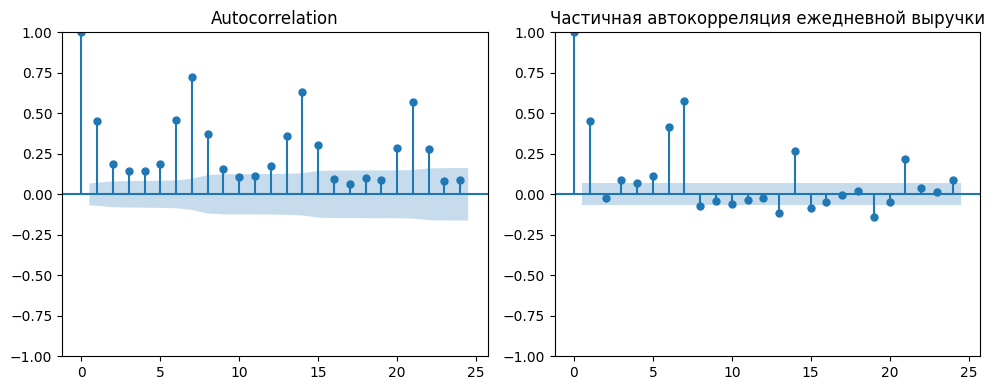

После дифференциации
ADF Statistic: -2.939796
p-value: 0.040912
	1%: -3.438
	5%: -2.865
	10%: -2.569


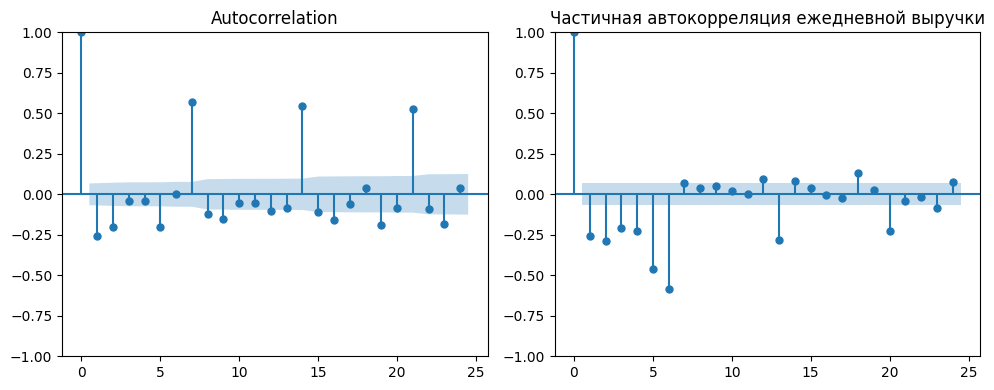

In [6]:
result = adfuller(df['Сумма без скидки, р.'])
print()
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


fig, axes = plt.subplots(1,2, figsize = (10,4))
axes = axes.ravel()
# Построение автокорреляции
plot_acf(df['Сумма без скидки, р.'], lags=24, ax=axes[0])
plt.title('Автокорреляция ежедневной выручки')
plot_pacf(df['Сумма без скидки, р.'], ax=axes[1], lags=24)
plt.title('Частичная автокорреляция ежедневной выручки')
plt.tight_layout()
plt.show()

print("="*50)
print('После дифференциации')

df_diff = df['Сумма без скидки, р.'].diff().dropna()

# Повторный тест ADF
result_diff = adfuller(df_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


fig, axes = plt.subplots(1,2, figsize = (10,4))
axes = axes.ravel()
# Построение автокорреляции
plot_acf(df_diff, lags=24, ax=axes[0])
plt.title('Автокорреляция ежедневной выручки')
plot_pacf(df_diff, ax=axes[1], lags=24)
plt.title('Частичная автокорреляция ежедневной выручки')
plt.tight_layout()
plt.show()

[I 2025-10-15 23:03:05,534] A new study created in memory with name: no-name-4b097d20-d14b-49ec-9807-e30719b5a05d


====================================================ARIMA not diff====================================================


[I 2025-10-15 23:04:01,289] Trial 0 finished with value: 543.3725317226422 and parameters: {'p': 5, 'd': 8, 'q': 11}. Best is trial 0 with value: 543.3725317226422.
[I 2025-10-15 23:04:11,867] Trial 1 finished with value: 1004.450363700386 and parameters: {'p': 0, 'd': 8, 'q': 9}. Best is trial 0 with value: 543.3725317226422.
[I 2025-10-15 23:04:18,673] Trial 2 finished with value: 640.3813630738573 and parameters: {'p': 10, 'd': 7, 'q': 1}. Best is trial 0 with value: 543.3725317226422.
[I 2025-10-15 23:04:25,058] Trial 3 finished with value: inf and parameters: {'p': 3, 'd': 10, 'q': 4}. Best is trial 0 with value: 543.3725317226422.
[I 2025-10-15 23:04:25,155] Trial 4 finished with value: 5011.845626991884 and parameters: {'p': 1, 'd': 7, 'q': 0}. Best is trial 0 with value: 543.3725317226422.
[I 2025-10-15 23:04:30,175] Trial 5 finished with value: 318.528114448792 and parameters: {'p': 6, 'd': 4, 'q': 6}. Best is trial 5 with value: 318.528114448792.
[I 2025-10-15 23:04:42,568] T

Лучшие параметры: {'p': 11, 'd': 0, 'q': 12}
Mean Absolute Error (MAE): 241.550
R^2: 0.109
Root Mean Squared Error (RMSE): 321.817
Mean Absolute Percentage Error (MAPE): 0.403%


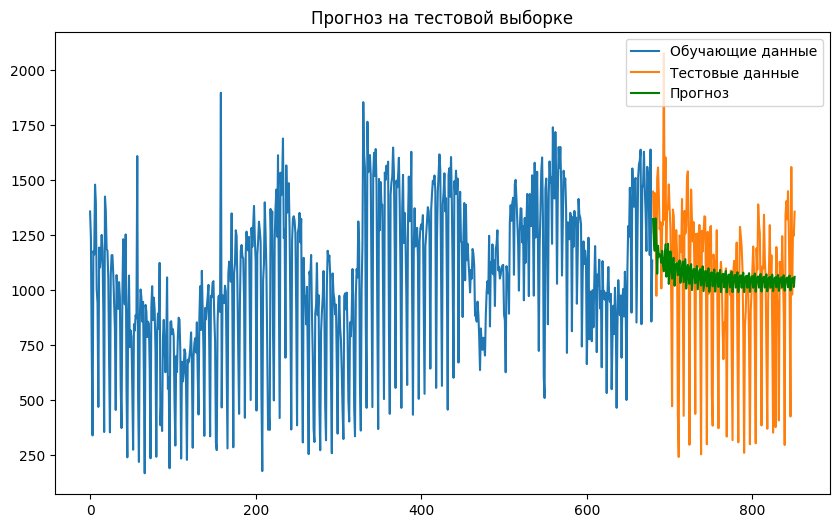

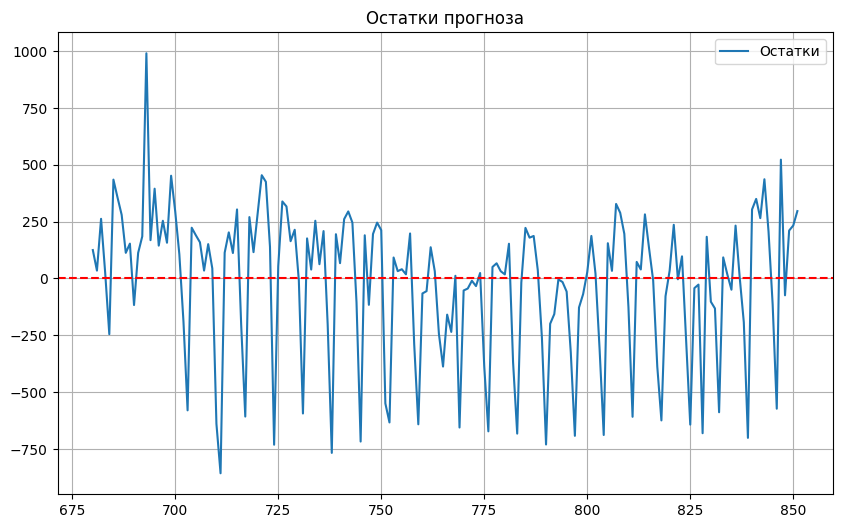

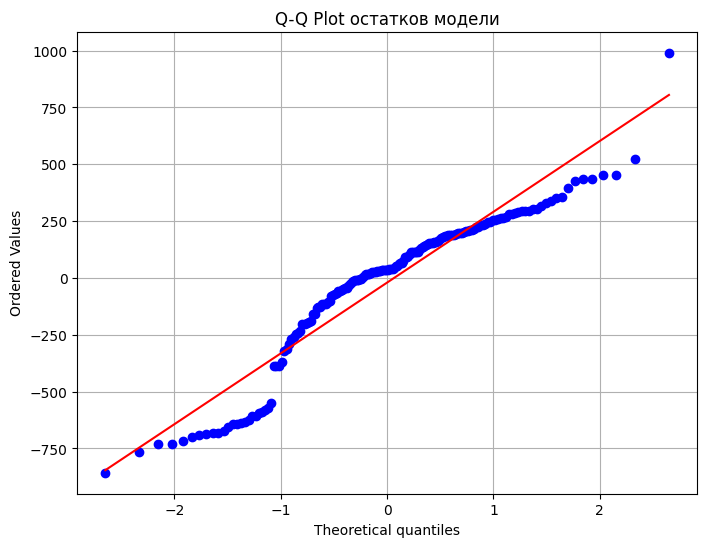

In [7]:
print('='*52 + 'ARIMA not diff' + '='*52)
warnings.filterwarnings("ignore")

train_df = df['Сумма без скидки, р.'].iloc[:680]
test_df = df['Сумма без скидки, р.'].iloc[680:]

def objective(trial):
    p = trial.suggest_int('p', 0, 12)
    d = trial.suggest_int('d', 0, 12)
    q = trial.suggest_int('q', 0, 12)

    try:
        model = ARIMA(train_df, order=(p, d, q))
        model_fit = model.fit()
        return model_fit.mae
    except (LinAlgError, ValueError) as e:
        # Optuna пропустит этот набор параметров и попробует другой
        return float('inf')


study = op.create_study(direction='minimize')
study.optimize(objective, n_trials=45)


print("Лучшие параметры:", study.best_params)

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params
model = ARIMA(train_df, order=(best_params['p'], best_params['d'], best_params['q']))
model_fit = model.fit()
forecast_test = model_fit.forecast(steps=len(test_df))

# Метрики качества
mae = mean_absolute_error(test_df, forecast_test)
mse = mean_squared_error(test_df, forecast_test)
rmse = root_mean_squared_error(test_df, forecast_test)
mape = mean_absolute_percentage_error(test_df, forecast_test)
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R^2: {r2_score(test_df, forecast_test):.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')

# Визуализация прогноза на тестовой выборке
plt.figure(figsize=(10, 6))
plt.plot(train_df, label='Обучающие данные')
plt.plot(np.arange(len(train_df), len(train_df) + len(test_df)), test_df, label='Тестовые данные')
plt.plot(np.arange(len(train_df), len(train_df) + len(test_df)), forecast_test, color='green', label='Прогноз')
plt.title('Прогноз на тестовой выборке')
plt.legend()
plt.show()


# Визуализация остатков
residuals = test_df - forecast_test
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Остатки')
plt.axhline(0, linestyle='--', color='red')
plt.title('Остатки прогноза')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot остатков модели')
plt.grid(True)
plt.show()

[I 2025-10-15 23:12:04,706] A new study created in memory with name: no-name-4159f165-fa25-4fa0-82d7-d353e6db38ee
[I 2025-10-15 23:12:06,118] Trial 0 finished with value: 29467.35649718657 and parameters: {'p': 3, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 'm': 7}. Best is trial 0 with value: 29467.35649718657.
[I 2025-10-15 23:12:24,450] Trial 1 finished with value: 28254.778044683346 and parameters: {'p': 3, 'd': 0, 'q': 1, 'P': 3, 'D': 1, 'Q': 3, 'm': 7}. Best is trial 1 with value: 28254.778044683346.
[I 2025-10-15 23:12:34,663] Trial 2 finished with value: 25592.501467204656 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 3, 'D': 0, 'Q': 3, 'm': 7}. Best is trial 2 with value: 25592.501467204656.
[I 2025-10-15 23:12:50,371] Trial 3 finished with value: 54693.903500318185 and parameters: {'p': 0, 'd': 3, 'q': 2, 'P': 3, 'D': 0, 'Q': 2, 'm': 7}. Best is trial 2 with value: 25592.501467204656.
[I 2025-10-15 23:12:53,291] Trial 4 finished with value: 49674.21071974682 and parameters: {'p':

Лучшие параметры: {'p': 2, 'd': 1, 'q': 4, 'P': 2, 'D': 0, 'Q': 1, 'm': 7}


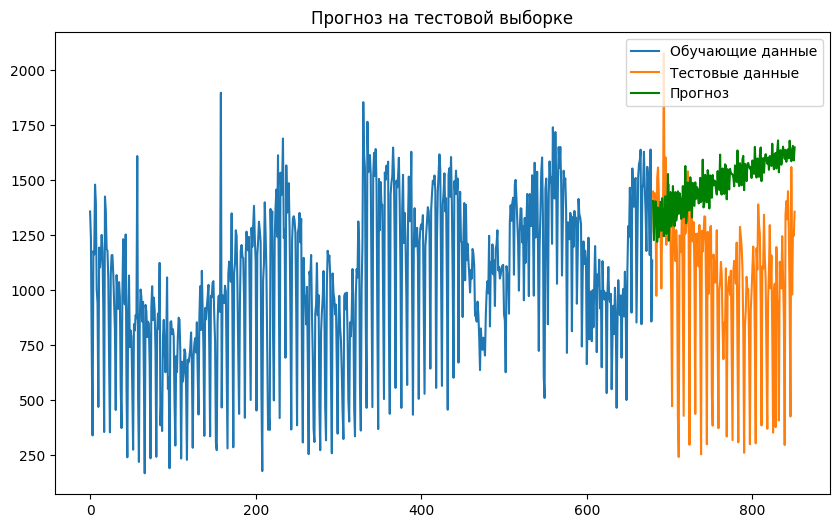

Mean Absolute Error (MAE): 471.308
R^2: -1.928
Root Mean Squared Error (RMSE): 583.272
Mean Absolute Percentage Error (MAPE): 77.226%


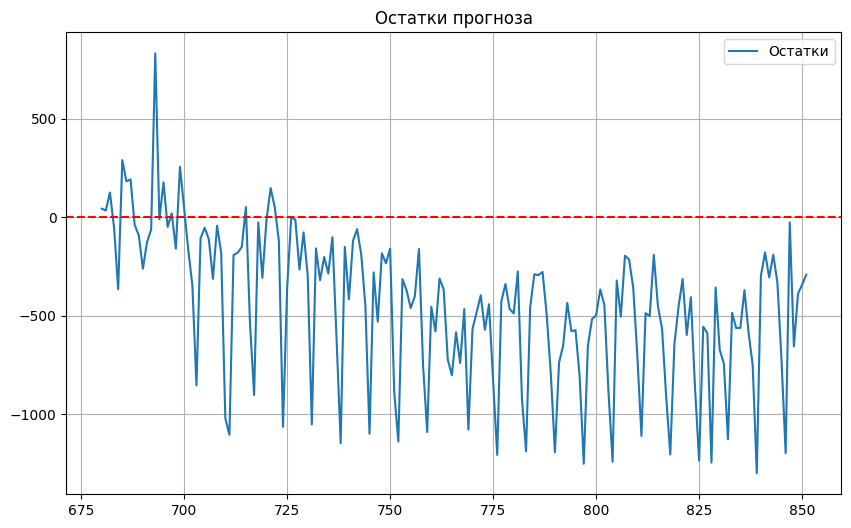

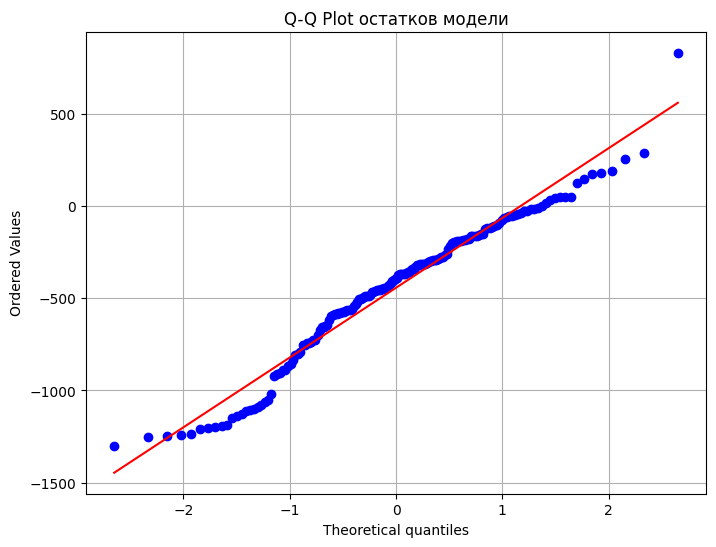

In [8]:

def objective(trial):
    p = trial.suggest_int('p', 0, 4)
    d = trial.suggest_int('d', 0, 4)
    q = trial.suggest_int('q', 0, 4)

    # Сезонные параметры
    P = trial.suggest_int('P', 0, 3)  # сезонный AR
    D = trial.suggest_int('D', 0, 2)  # сезонная дифференциация
    Q = trial.suggest_int('Q', 0, 3)  # сезонный MA
    m = trial.suggest_int('m', 7, 7)  # период сезонности (фиксируем 7 дней)

    try:
      model = SARIMAX(train_df, order=(p, d, q), seasonal_order=(P, D, Q, m))
      model_fit = model.fit()
      return (model_fit.mae*0.5 + model_fit.mse*0.5)
    except (LinAlgError, ValueError) as e:
        # Optuna пропустит этот набор параметров и попробует другой
        return float('inf')

study = op.create_study(direction='minimize')
study.optimize(objective, n_trials=25)


print("Лучшие параметры:", study.best_params)

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params
model = SARIMAX(train_df, order=(best_params['p'], best_params['d'], best_params['q']),
              seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m']))
model_fit = model.fit()
forecast_test = model_fit.forecast(steps=len(test_df))

# Визуализация прогноза на тестовой выборке
plt.figure(figsize=(10, 6))
plt.plot(train_df, label='Обучающие данные')
plt.plot(np.arange(len(train_df), len(train_df) + len(test_df)), test_df, label='Тестовые данные')
plt.plot(np.arange(len(train_df), len(train_df) + len(test_df)), forecast_test, color='green', label='Прогноз')
plt.title('Прогноз на тестовой выборке')
plt.legend()
plt.show()

# Метрики качества
mae = mean_absolute_error(test_df, forecast_test)
mse = mean_squared_error(test_df, forecast_test)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_df - forecast_test) / test_df)) * 100

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R^2: {r2_score(test_df, forecast_test):.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')

# Визуализация остатков
residuals = test_df - forecast_test
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Остатки')
plt.axhline(0, linestyle='--', color='red')
plt.title('Остатки прогноза')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot остатков модели')
plt.grid(True)
plt.show()


[I 2025-10-15 23:16:31,230] A new study created in memory with name: no-name-d50e80fb-8371-49be-9740-765cdb56db4f


====================================================ARIMA diff====================================================


[I 2025-10-15 23:16:38,074] Trial 0 finished with value: 208.7916293828485 and parameters: {'p': 7, 'd': 4, 'q': 5}. Best is trial 0 with value: 208.7916293828485.
[I 2025-10-15 23:16:42,639] Trial 1 finished with value: 163.46059477640247 and parameters: {'p': 8, 'd': 0, 'q': 6}. Best is trial 1 with value: 163.46059477640247.
[I 2025-10-15 23:16:55,178] Trial 2 finished with value: 259.49631283612456 and parameters: {'p': 1, 'd': 4, 'q': 10}. Best is trial 1 with value: 163.46059477640247.
[I 2025-10-15 23:17:03,249] Trial 3 finished with value: 301.98770692877866 and parameters: {'p': 9, 'd': 5, 'q': 5}. Best is trial 1 with value: 163.46059477640247.
[I 2025-10-15 23:17:06,201] Trial 4 finished with value: 226.8051510852041 and parameters: {'p': 10, 'd': 2, 'q': 0}. Best is trial 1 with value: 163.46059477640247.
[I 2025-10-15 23:17:08,010] Trial 5 finished with value: 166.98483643820478 and parameters: {'p': 8, 'd': 0, 'q': 2}. Best is trial 1 with value: 163.46059477640247.
[I 20

Лучшие параметры: {'p': 9, 'd': 0, 'q': 9}
Mean Absolute Error (MAE): 294.495
R^2: 0.096
Root Mean Squared Error (RMSE): 391.341
Mean Absolute Percentage Error (MAPE): 1.457%


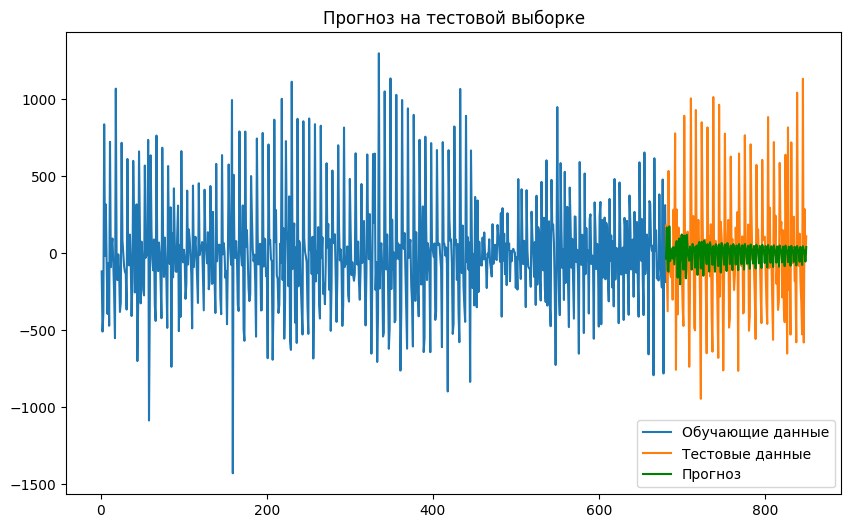

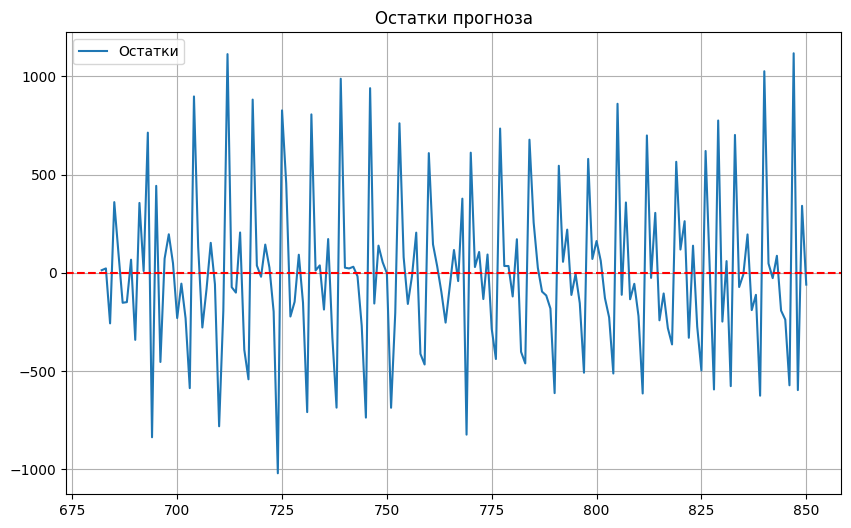

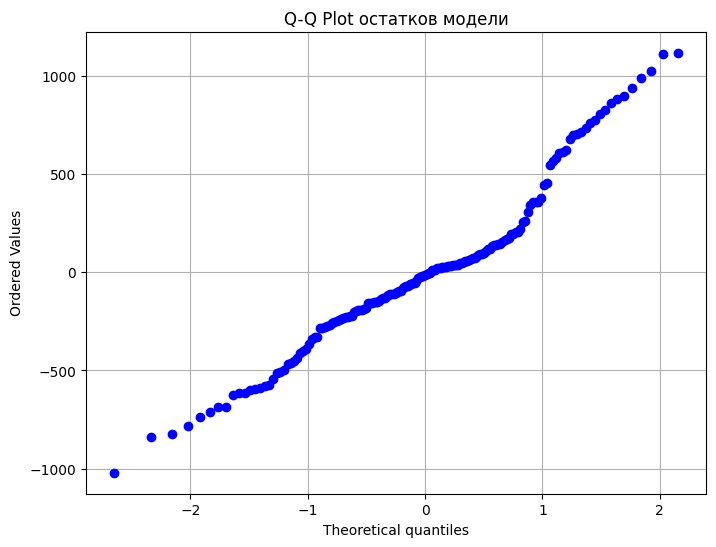

In [9]:
"""ДИФФЕРЕНЦИРОВАННЫЕ ДАННЫЕ"""
"""ARIMA diff"""

print('='*52 + "ARIMA diff" + '='*52)
warnings.filterwarnings("ignore")

train_diff = df_diff.iloc[0:681]
test_diff = df_diff.iloc[681:]

def objective(trial):
    p = trial.suggest_int('p', 0, 10)
    d = trial.suggest_int('d', 0, 5)
    q = trial.suggest_int('q', 0, 10)

    try:
        model = ARIMA(train_diff, order=(p, d, q))
        model_fit = model.fit()
        return model_fit.mae
    except (LinAlgError, ValueError):
        return float('inf')


study = op.create_study(direction='minimize')
study.optimize(objective, n_trials=25)


print("Лучшие параметры:", study.best_params)

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params
model = ARIMA(train_diff, order=(best_params['p'], best_params['d'], best_params['q']))
model_fit = model.fit()
forecast_test = model_fit.forecast(steps=len(test_diff))

# Метрики качества
mae = mean_absolute_error(test_diff, forecast_test)
mse = mean_squared_error(test_diff, forecast_test)
rmse = root_mean_squared_error(test_diff, forecast_test)
mape = mean_absolute_percentage_error(test_diff, forecast_test)
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R^2: {r2_score(test_diff, forecast_test):.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')

# Визуализация прогноза на тестовой выборке
plt.figure(figsize=(10, 6))
plt.plot(train_diff, label='Обучающие данные')
plt.plot(np.arange(len(train_diff), len(train_diff) + len(test_diff)), test_diff, label='Тестовые данные')
plt.plot(np.arange(len(train_diff), len(train_diff) + len(test_diff)), forecast_test, color='green', label='Прогноз')
plt.title('Прогноз на тестовой выборке')
plt.legend()
plt.show()


# Визуализация остатков
residuals = test_diff - forecast_test
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Остатки')
plt.axhline(0, linestyle='--', color='red')
plt.title('Остатки прогноза')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot остатков модели')
plt.grid(True)
plt.show()

[I 2025-10-15 23:19:20,255] A new study created in memory with name: no-name-1d87743c-58b2-410f-a592-efa2e31017b8
[I 2025-10-15 23:19:33,149] Trial 0 finished with value: 190.57311764950876 and parameters: {'p': 1, 'd': 1, 'q': 3, 'P': 1, 'D': 2, 'Q': 1, 'm': 7}. Best is trial 0 with value: 190.57311764950876.
[I 2025-10-15 23:19:50,220] Trial 1 finished with value: 217.3981622194303 and parameters: {'p': 4, 'd': 2, 'q': 1, 'P': 3, 'D': 1, 'Q': 2, 'm': 7}. Best is trial 0 with value: 190.57311764950876.
[I 2025-10-15 23:19:55,440] Trial 2 finished with value: 193.04206167696884 and parameters: {'p': 0, 'd': 1, 'q': 3, 'P': 0, 'D': 2, 'Q': 1, 'm': 7}. Best is trial 0 with value: 190.57311764950876.
[I 2025-10-15 23:20:00,516] Trial 3 finished with value: 240.25105438374482 and parameters: {'p': 4, 'd': 2, 'q': 2, 'P': 1, 'D': 0, 'Q': 0, 'm': 7}. Best is trial 0 with value: 190.57311764950876.
[I 2025-10-15 23:20:14,610] Trial 4 finished with value: 328.61850793241064 and parameters: {'p

Лучшие параметры: {'p': 4, 'd': 0, 'q': 2, 'P': 0, 'D': 1, 'Q': 4, 'm': 7}


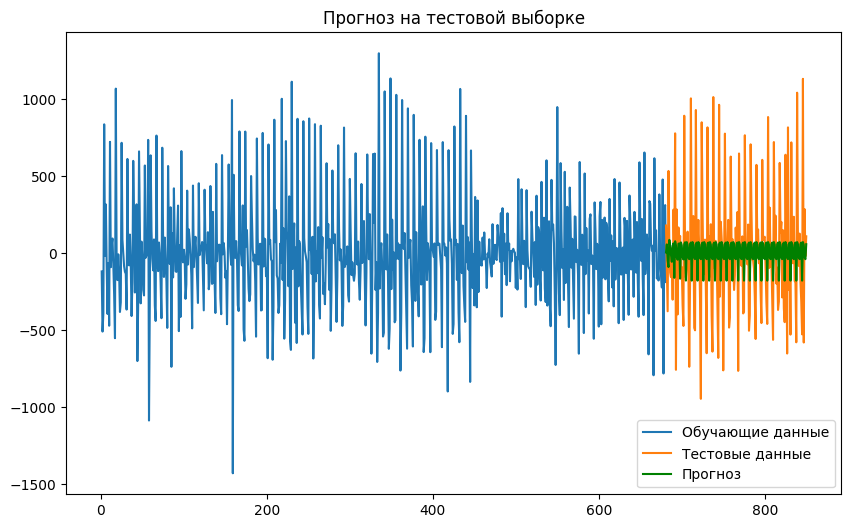

Mean Absolute Error (MAE): 295.134
R^2: 0.111
Root Mean Squared Error (RMSE): 388.054
Mean Absolute Percentage Error (MAPE): 43.840%


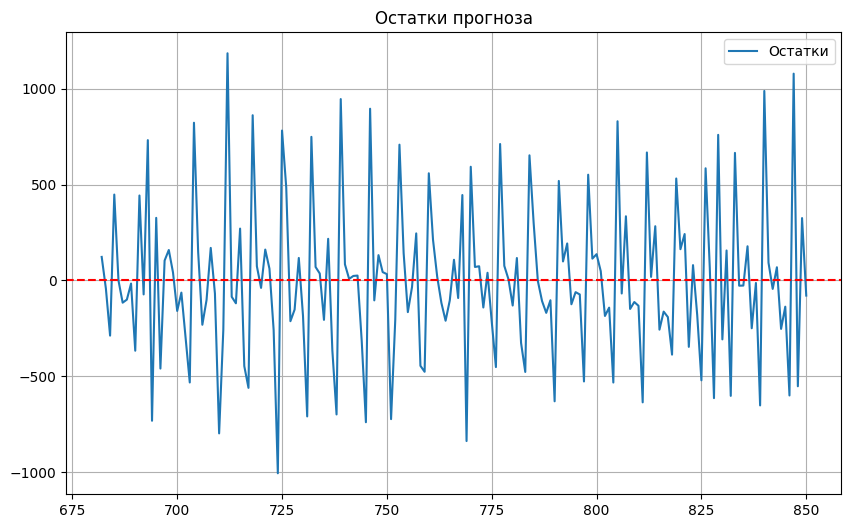

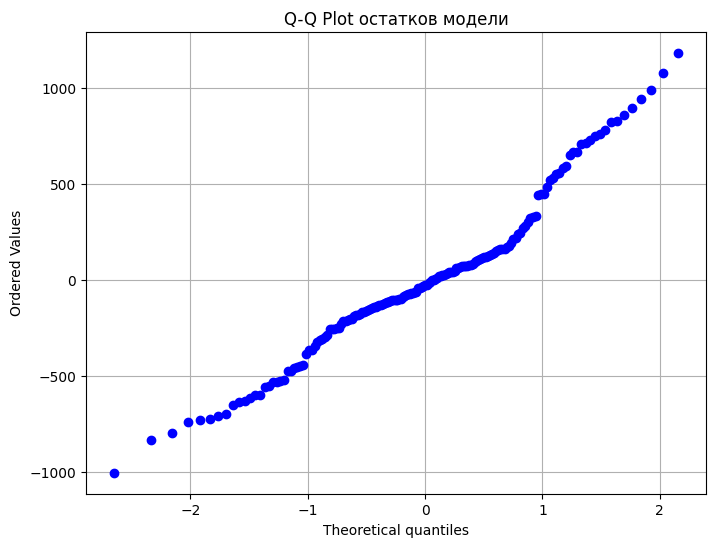

In [10]:

def objective(trial):
    p = trial.suggest_int('p', 0, 4)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)

    # Сезонные параметры
    P = trial.suggest_int('P', 0, 3)  # сезонный AR
    D = trial.suggest_int('D', 0, 2)  # сезонная дифференциация
    Q = trial.suggest_int('Q', 0, 4)  # сезонный MA
    m = trial.suggest_int('m', 7, 7)  # период сезонности (фиксируем 7 дней)

    try:
        model = SARIMAX(train_diff, order=(p, d, q), seasonal_order=(P, D, Q, m))
        model_fit = model.fit()
        return model_fit.mae
    except(LinAlgError, ValueError):
        return float('inf')


study = op.create_study(direction='minimize')
study.optimize(objective, n_trials=45)


print("Лучшие параметры:", study.best_params)

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params
model = SARIMAX(train_diff, order=(best_params['p'], best_params['d'], best_params['q']),
              seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['m']))
model_fit = model.fit()
forecast_test = model_fit.forecast(steps=len(test_diff))

# Визуализация прогноза на тестовой выборке
plt.figure(figsize=(10, 6))
plt.plot(train_diff, label='Обучающие данные')
plt.plot(np.arange(len(train_diff), len(train_diff) + len(test_diff)), test_diff, label='Тестовые данные')
plt.plot(np.arange(len(train_diff), len(train_diff) + len(test_diff)), forecast_test, color='green', label='Прогноз')
plt.title('Прогноз на тестовой выборке')
plt.legend()
plt.show()

# Метрики качества
mae = mean_absolute_error(test_diff, forecast_test)
mse = mean_squared_error(test_diff, forecast_test)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_diff - forecast_test) / test_df)) * 100

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R^2: {r2_score(test_diff, forecast_test):.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')

# Визуализация остатков
residuals = test_diff - forecast_test
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Остатки')
plt.axhline(0, linestyle='--', color='red')
plt.title('Остатки прогноза')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot остатков модели')
plt.grid(True)
plt.show()

Epoch 1/50
756/756 - 8s - 11ms/step - loss: 0.0265
Epoch 2/50
756/756 - 5s - 6ms/step - loss: 0.0200
Epoch 3/50
756/756 - 5s - 7ms/step - loss: 0.0182
Epoch 4/50
756/756 - 6s - 7ms/step - loss: 0.0169
Epoch 5/50
756/756 - 11s - 14ms/step - loss: 0.0169
Epoch 6/50
756/756 - 5s - 6ms/step - loss: 0.0162
Epoch 7/50
756/756 - 5s - 6ms/step - loss: 0.0153
Epoch 8/50
756/756 - 6s - 8ms/step - loss: 0.0152
Epoch 9/50
756/756 - 5s - 6ms/step - loss: 0.0154
Epoch 10/50
756/756 - 6s - 8ms/step - loss: 0.0147
Epoch 11/50
756/756 - 5s - 6ms/step - loss: 0.0143
Epoch 12/50
756/756 - 5s - 6ms/step - loss: 0.0144
Epoch 13/50
756/756 - 6s - 8ms/step - loss: 0.0137
Epoch 14/50
756/756 - 5s - 6ms/step - loss: 0.0137
Epoch 15/50
756/756 - 6s - 8ms/step - loss: 0.0137
Epoch 16/50
756/756 - 5s - 7ms/step - loss: 0.0130
Epoch 17/50
756/756 - 5s - 6ms/step - loss: 0.0131
Epoch 18/50
756/756 - 7s - 9ms/step - loss: 0.0129
Epoch 19/50
756/756 - 5s - 6ms/step - loss: 0.0131
Epoch 20/50
756/756 - 5s - 7ms/step -

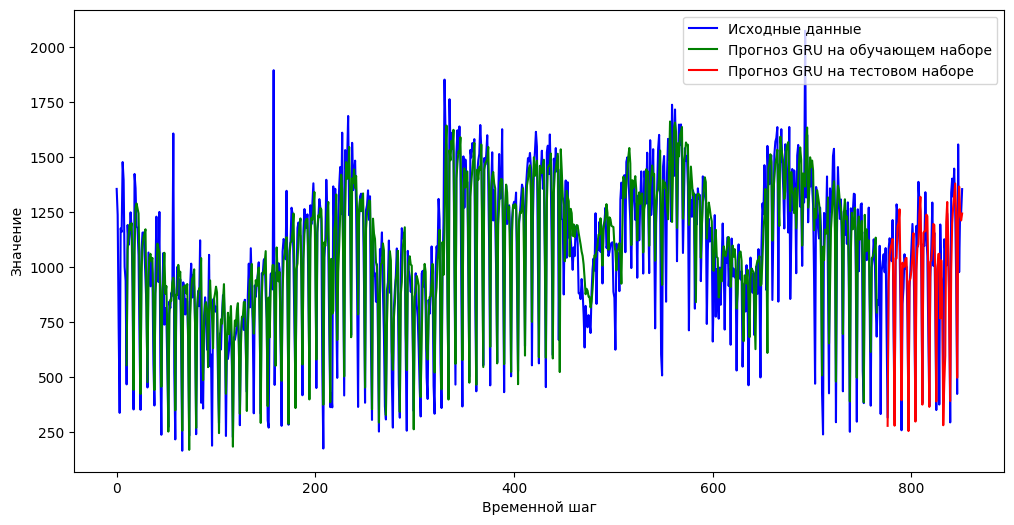

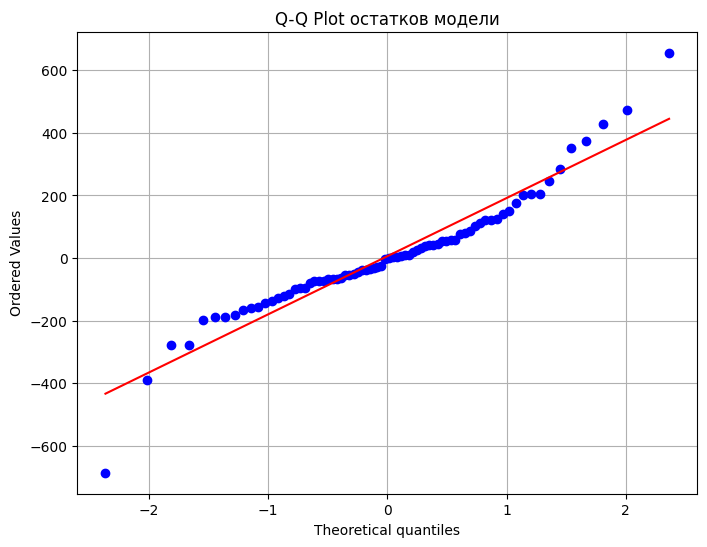

In [11]:
series = np.array(df['Сумма без скидки, р.'])

scaler = MinMaxScaler()
series = scaler.fit_transform(series.reshape(-1, 1))
train_size = int(len(series)* 0.9)

train_data, test_data = series[:train_size], series[train_size:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back)])
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)

look_back = 10  # Количество предыдущих временных шагов для учитывания

X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)


# Подготовка данных в формате (количество примеров, количество временных шагов, количество признаков)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Создаем модель LSTM
model_gru = Sequential()
model_gru.add(GRU(units=100, activation=None, input_shape=(look_back, 1)))
model_gru.add(Dense(units=1))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Обучаем модель LSTM
model_gru.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)

mae = mean_absolute_error(df['Сумма без скидки, р.'].iloc[len(series)-76:], test_predict_gru.flatten())
mse = mean_squared_error(df['Сумма без скидки, р.'].iloc[len(series)-76:], test_predict_gru.flatten())
rmse = root_mean_squared_error(df['Сумма без скидки, р.'].iloc[len(series)-76:], test_predict_gru.flatten())
mape = mean_absolute_percentage_error(df['Сумма без скидки, р.'].iloc[len(series)-76:], test_predict_gru.flatten())
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R^2: {r2_score(df['Сумма без скидки, р.'].iloc[len(series)-76:], test_predict_gru.flatten()):.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')

train_plot_gru = np.empty_like(series)
train_plot_gru[:] = np.nan
train_plot_gru[look_back:len(train_predict_gru) + look_back, 0] = train_predict_gru[:, 0]

test_plot_gru = np.empty_like(series)
test_plot_gru[:] = np.nan
offset = len(train_predict_gru) + (look_back * 2)
test_plot_gru[offset:len(test_predict_gru) + offset, 0] = test_predict_gru[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(series), label='Исходные данные', color='blue')
plt.plot(train_plot_gru, label='Прогноз GRU на обучающем наборе', color='green')
plt.plot(test_plot_gru, label='Прогноз GRU на тестовом наборе', color='red')
plt.xlabel('Временной шаг')
plt.ylabel('Значение')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
stats.probplot(df['Сумма без скидки, р.'].iloc[len(series)-76:] - test_predict_gru.flatten(), dist="norm", plot=plt)
plt.title('Q-Q Plot остатков модели')
plt.grid(True)
plt.show()

Общее количество точек: 852
Форма последовательностей: (843, 10)
Форма масштабированных данных: (843, 10)

=== Dense автоэнкодер ===


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 449)            │         4,939 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,141 (801.33 KB)

 Trainable params: 205,141 (801.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.7623 - val_loss: 0.5494
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.4809 - val_loss: 0.4200
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3513 - val_loss: 0.3241
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2681 - val_loss: 0.2702
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2231 - val_loss: 0.2157
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1795 - val_loss: 0.1804
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1504 - val_loss: 0.1496
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1185 - val_loss: 0.1143
Epoch 9/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0914 - val_loss: 0.0928
Epoch 10/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0935 - val_loss: 0.1050
Epoch 11/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0953 - val_loss: 0.0981
Epoch 12/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0831 - val_loss: 0.0934
E

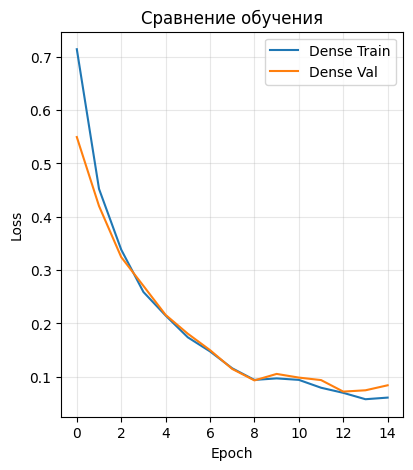

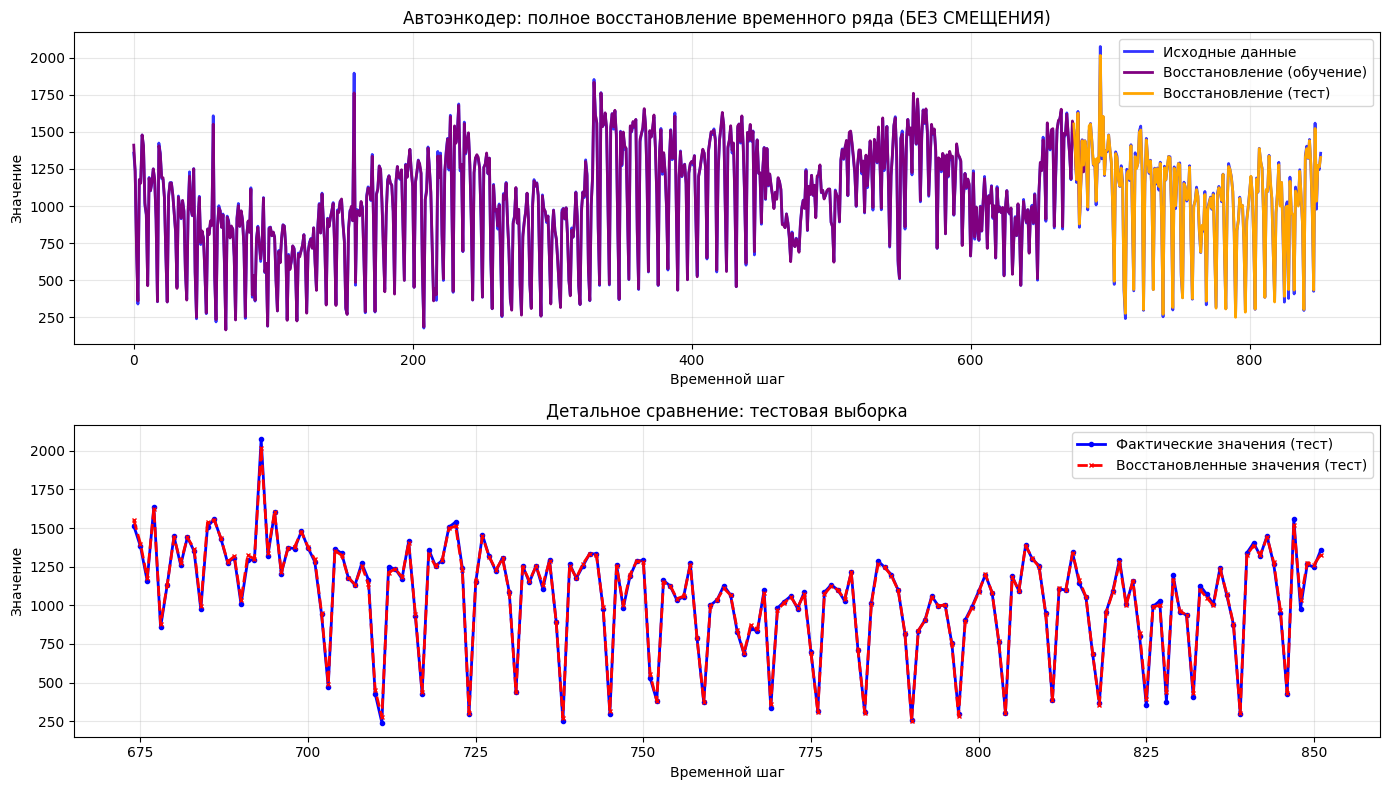

Mean Absolute Error (MAE): 0.084
R^2: 0.988
Root Mean Squared Error (RMSE): 0.105
Mean Absolute Percentage Error (MAPE): 0.329%


In [14]:
# Параметры
sequence_length = 10
data = df['Сумма без скидки, р.'].values

print(f"Общее количество точек: {len(data)}")

# Создание последовательностей
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

# Создаем последовательности
sequences = create_sequences(data, sequence_length)
print(f"Форма последовательностей: {sequences.shape}")

# Масштабирование
scaler = StandardScaler()
sequences_scaled = scaler.fit_transform(sequences.reshape(-1, 1)).reshape(sequences.shape)

print(f"Форма масштабированных данных: {sequences_scaled.shape}")

# Разделение на train/test
train_size = int(0.8 * len(sequences_scaled))
X_train = sequences_scaled[:train_size]
X_test = sequences_scaled[train_size:]

print("\n=== Dense автоэнкодер ===")

input_layer = Input(shape=(sequence_length,))
encoded = Dense(449, activation='relu')(input_layer)
encoded = Dense(256, activation='relu')(encoded)
encoded = Dense(128, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(sequence_length, activation='linear')(decoded)

autoencoder_dense = Model(input_layer, decoded)
autoencoder_dense.compile(optimizer=Adam(0.001), loss='mae')
autoencoder_dense.summary()

# Обучение
history_dense = autoencoder_dense.fit(
    X_train, X_train,
    epochs=15,
    batch_size=100,
    shuffle=True,
    validation_data=(X_test, X_test)
)


# 1. Графики обучения
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_dense.history['loss'], label='Dense Train')
plt.plot(history_dense.history['val_loss'], label='Dense Val')
plt.title('Сравнение обучения')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Прогнозы
train_predict_dense = autoencoder_dense.predict(X_train)
test_predict_dense = autoencoder_dense.predict(X_test)

# Инвертируем масштабирование
train_predict_dense_unscaled = scaler.inverse_transform(train_predict_dense.reshape(-1, 1)).reshape(train_predict_dense.shape)
test_predict_dense_unscaled = scaler.inverse_transform(test_predict_dense.reshape(-1, 1)).reshape(test_predict_dense.shape)

# ВОССТАНОВЛЕНИЕ ПОЛНОГО ВРЕМЕННОГО РЯДА БЕЗ СМЕЩЕНИЯ
def reconstruct_full_series_no_shift(original_sequences, reconstructed_sequences, seq_length):
    """
    Восстанавливает полный ряд без смещения, усредняя перекрывающиеся прогнозы
    """
    full_length = len(original_sequences) + seq_length - 1
    reconstructed_full = np.zeros(full_length)
    counts = np.zeros(full_length)

    for i, (orig_seq, recon_seq) in enumerate(zip(original_sequences, reconstructed_sequences)):
        # Для каждой позиции в последовательности добавляем соответствующий прогноз
        for j in range(seq_length):
            idx = i + j
            if idx < full_length:
                reconstructed_full[idx] += recon_seq[j]
                counts[idx] += 1

    # Усредняем
    reconstructed_full = reconstructed_full / np.maximum(counts, 1)
    return reconstructed_full

# Восстанавливаем полные ряды
full_train_reconstructed = reconstruct_full_series_no_shift(X_train, train_predict_dense_unscaled, sequence_length)
full_test_reconstructed = reconstruct_full_series_no_shift(X_test, test_predict_dense_unscaled, sequence_length)

# Создаем правильные временные индексы
time_index = np.arange(len(data))

# Визуализация БЕЗ СМЕЩЕНИЯ
plt.figure(figsize=(14, 8))

# 1. Полная визуализация
plt.subplot(2, 1, 1)
plt.plot(time_index, data, label='Исходные данные', color='blue', linewidth=2, alpha=0.8)

# Обучающая часть
train_end_idx = len(full_train_reconstructed)
plt.plot(time_index[:train_end_idx], full_train_reconstructed,
         label='Восстановление (обучение)', color='purple', linewidth=2)

# Тестовая часть (продолжение)
test_start_idx = train_size
test_indices = time_index[test_start_idx:test_start_idx + len(full_test_reconstructed)]
plt.plot(test_indices, full_test_reconstructed,
         label='Восстановление (тест)', color='orange', linewidth=2)

plt.xlabel('Временной шаг')
plt.ylabel('Значение')
plt.title('Автоэнкодер: полное восстановление временного ряда (БЕЗ СМЕЩЕНИЯ)')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Детальная визуализация тестовой части
plt.subplot(2, 1, 2)
test_actual = data[test_start_idx:test_start_idx + len(full_test_reconstructed)]

plt.plot(test_indices, test_actual, label='Фактические значения (тест)',
         color='blue', linewidth=2, marker='o', markersize=3)
plt.plot(test_indices, full_test_reconstructed, label='Восстановленные значения (тест)',
         color='red', linewidth=2, linestyle='--', marker='x', markersize=3)

plt.xlabel('Временной шаг')
plt.ylabel('Значение')
plt.title('Детальное сравнение: тестовая выборка')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

mae = mean_absolute_error(X_test, test_predict_dense)
mse = mean_squared_error(X_test, test_predict_dense)
rmse = root_mean_squared_error(X_test, test_predict_dense)
mape = mean_absolute_percentage_error(X_test, test_predict_dense)
print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'R^2: {r2_score(X_test, test_predict_dense):.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.3f}%')


Создание мета-признаков...
Creating meta-features: Fold 1/5
Creating meta-features: Fold 2/5
Creating meta-features: Fold 3/5
Creating meta-features: Fold 4/5
Creating meta-features: Fold 5/5
Обучение мета-модели...
Финальное обучение базовых моделей...
Статистика производительности:
tree_based: MAE = 23.55
 R^2 = 0.99
boosting: MAE = 15.44
 R^2 = 0.99
linear: MAE = 43.20
 R^2 = 0.96
Stacking MAE = 47.67
Stacking R^2 = 0.95


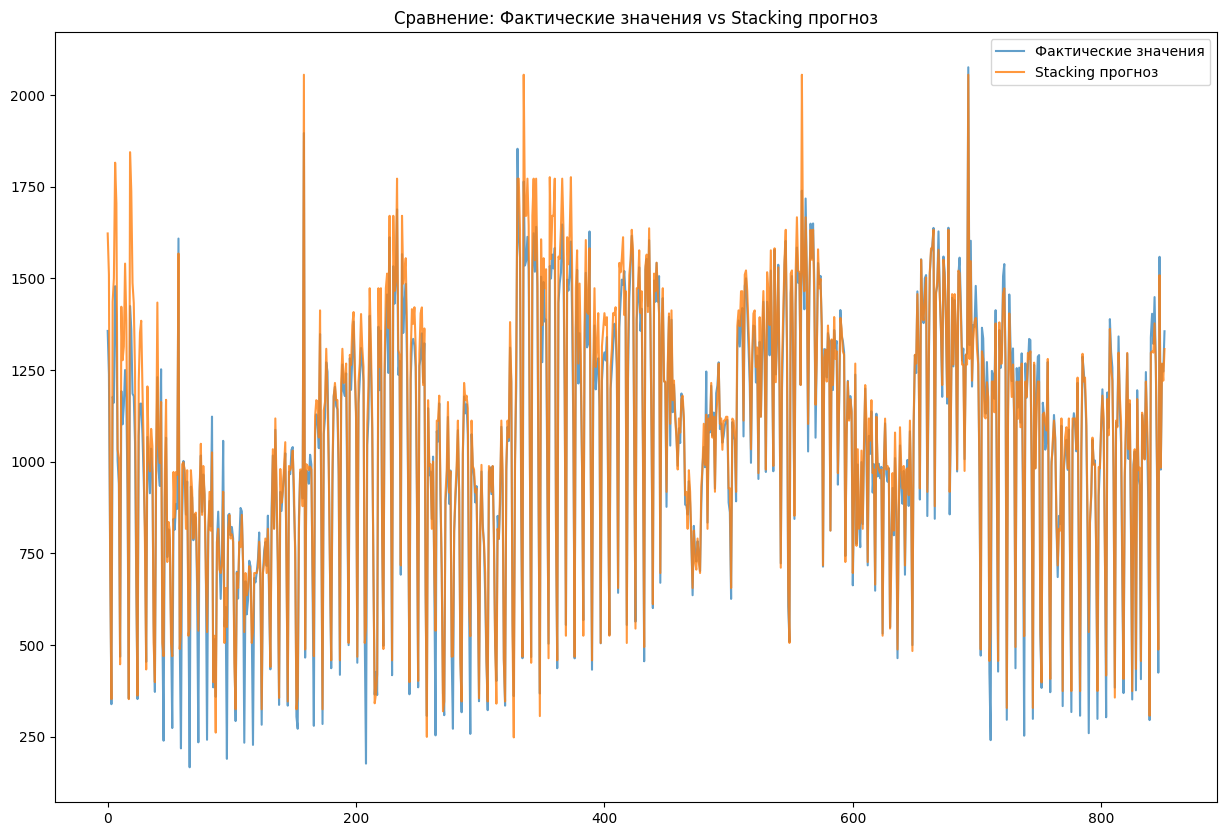

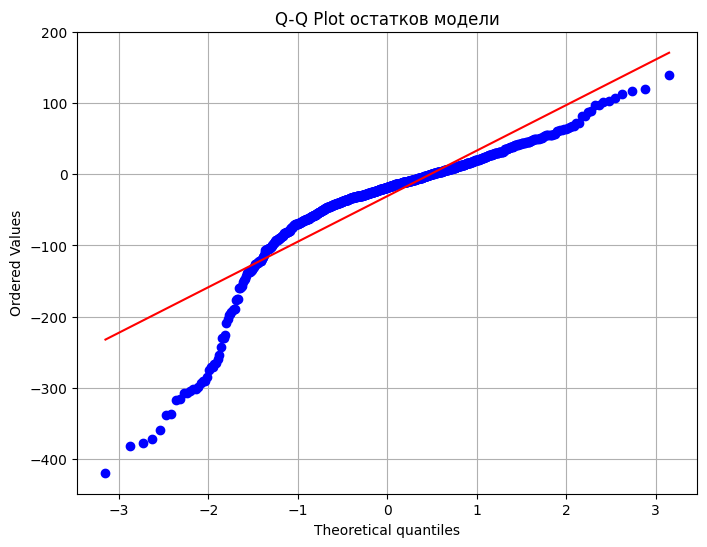

In [15]:
import lightgbm as lgb

X = df.drop(['Сумма без скидки, р.', 'Учетный день'], axis=1)
y = df['Сумма без скидки, р.']

base_models = {
  'tree_based': RandomForestRegressor(n_estimators=100, random_state=42,max_depth=6, criterion='absolute_error'),
  'boosting': lgb.LGBMRegressor(verbose=-1, num_leaves=21),
  'linear': Ridge(alpha=0.1)
  }
meta_model = XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
stacking_model = None

def create_meta_features(X, y, n_splits=5):
    """Создание мета-признаков через временную CV"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    meta_features = np.zeros((len(X), len(base_models)))

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        print(f"Creating meta-features: Fold {fold + 1}/{n_splits}")

        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        for i, (name, model) in enumerate(base_models.items()):
            # Обучаем модель
            model.fit(X_train, y_train)
            pred = model.predict(X_val)
            meta_features[val_idx, i] = pred

    return meta_features

def fit(X, y):
    """Обучение продвинутого stacking"""
    print("Создание мета-признаков...")
    meta_features = create_meta_features(X, y)

    print("Обучение мета-модели...")
    meta_model.fit(meta_features, y)

    # Переобучаем базовые модели на всех данных
    print("Финальное обучение базовых моделей...")
    for name, model in base_models.items():
        if name == 'neural':
            X_reshaped = X.values.reshape((X.shape[0], X.shape[1], 1))
            model.model.fit(X_reshaped, y, epochs=30, verbose=0)
        else:
            model.fit(X, y)

    is_fitted = True
    return None

def predict(X):
    """Прогноз"""
    # Прогнозы базовых моделей
    base_preds = np.zeros((len(X), len(base_models)))

    for i, (name, model) in enumerate(base_models.items()):
      base_preds[:, i] = model.predict(X)

    # Финальный прогноз мета-модели
    return meta_model.predict(base_preds)

# Использование
X.columns = [f'feature_{i}' for i in range(X.shape[1])]
fit(X, y)
predictions_advanced = predict(X)

def evaluate_stacking_performance(y_true, y_pred, base_predictions, model_names):
    """Оценка и визуализация производительности stacking"""

    plt.figure(figsize=(15, 10))

    # 1. Сравнение прогнозов
    plt.plot(y_true.values, label='Фактические значения', alpha=0.7)
    plt.plot(y_pred, label='Stacking прогноз', alpha=0.8)
    plt.title('Сравнение: Фактические значения vs Stacking прогноз')
    plt.legend()

    # 2. Ошибки базовых моделей vs stacking

    mae_ = []
    r2_ = []
    labels = []

    # Ошибки базовых моделей
    for i, name in enumerate(model_names):
        mae = mean_absolute_error(y_true, base_predictions[:, i])
        r2 = r2_score(y_true, base_predictions[:, i])
        mae_.append(mae)
        r2_.append(r2)
        labels.append(name)

    # Ошибка stacking
    stacking_mae = mean_absolute_error(y_true, y_pred)
    stacking_r2 = r2_score(y_true, y_pred)
    mae_.append(stacking_mae)
    r2_.append(stacking_r2)
    labels.append('Stacking')


    # Статистика
    print("Статистика производительности:")
    for i, name in enumerate(model_names):
        # mae = mean_absolute_error(y_true, base_predictions[:, i])
        print(f"{name}: MAE = {mae_[i]:.2f}\n R^2 = {r2_[i]:.2f}")


    print(f"Stacking MAE = {stacking_mae:.2f}")
    print(f"Stacking R^2 = {stacking_r2:.2f}")

# Визуализация
base_preds_matrix = np.column_stack([model.predict(X) for model in base_models.values()])
evaluate_stacking_performance(y, predictions_advanced, base_preds_matrix, list(base_models.keys()))
plt.figure(figsize=(8, 6))
stats.probplot(y - predictions_advanced, dist="norm", plot=plt)
plt.title('Q-Q Plot остатков модели')
plt.grid(True)
plt.show()